In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import re
import xgboost as xgb

from bert_serving.client import BertClient
from spellchecker import SpellChecker

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Tweet train data from Kaggle
df = pd.read_csv('/DataScience/nlp-getting-started/train.csv')
df = df.iloc[:, 1:].drop_duplicates()
df.reset_index(inplace=True)

# List of 15,000 cities from around the world, as well as countries
cities = pd.read_csv('/DataScience/simplemaps_worldcities_basicv1.6/worldcities.csv')

test_df = pd.read_csv('/DataScience/nlp-getting-started/test.csv')

In [49]:
df.head()

,index,keyword,location,text,target
0,0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [50]:
df.drop('index', 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 4 columns):
keyword     7500 non-null object
location    5061 non-null object
text        7561 non-null object
target      7561 non-null int64
dtypes: int64(1), object(3)
memory usage: 236.4+ KB


KeyError: "['index'] not found in axis"

In [ ]:
cities.head()

In [ ]:
word_lengths_disaster, word_lengths_not = [], []
word_size_disaster, word_size_not = [], []
for tweet in range(len(df)):
    if df.target[tweet] == 1:
        word_lengths_disaster.append(len(df.text[tweet].split()))
        for word in df.text[tweet].split():
            word_size_disaster.append(len(word))
    else:
        word_lengths_not.append(len(df.text[tweet].split()))
        for word in df.text[tweet].split():
            word_size_not.append(len(word))
print('Mean length of disaster tweets:', np.mean(word_lengths_disaster))
print('Mean length of not disaster tweets:', np.mean(word_lengths_not))
print('\nMean word length of disaster tweets:', np.mean(word_size_disaster))
print('Mean word length of disaster tweets:', np.mean(word_size_not))
print('\nMedian word length of disaster tweets:', np.median(word_size_disaster))
print('Median word length of disaster tweets:', np.median(word_size_not))

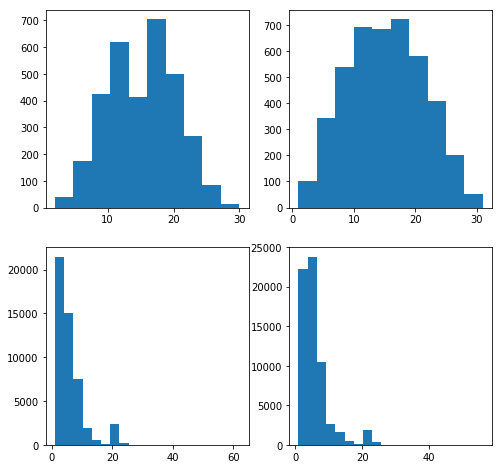

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
axes[0, 0].hist(word_lengths_disaster)
axes[0, 1].hist(word_lengths_not)
axes[1, 0].hist(word_size_disaster, bins=20)
axes[1, 1].hist(word_size_not, bins=20)
plt.show()

Disaster tweets have more words in them, and also use longer words. The median word length is more different than the mean, so I might use that as a feature instead of the mean.

In [52]:
texts = df.text
spell = SpellChecker()
new_texts = []
median_word_lengths = []

for text in texts:
    text = re.sub(r'[^\w\s]', '', text).lower().split()
    for word in range(len(text)):
        if text[word][:4] == 'http':
            text[word] = ' '
    misspelled = spell.unknown(text)
    for word in range(len(text)):
        if text[word] in misspelled:
            text[word] = spell.correction(text[word])
    word_lengths = []
    for word in text:
        word_lengths.append(len(word))
    median_word_lengths.append(np.median(word_lengths))
    text = (' ').join(text)
    new_texts.append(text)
df['WordLength'] = median_word_lengths
df['text'] = new_texts

In [53]:
texts = test_df.text
spell = SpellChecker()
new_texts = []
median_word_lengths = []

for text in texts:
    text = re.sub(r'[^\w\s]', '', text).lower().split()
    for word in range(len(text)):
        if text[word][:4] == 'http':
            text[word] = ' '
    misspelled = spell.unknown(text)
    for word in range(len(text)):
        if text[word] in misspelled:
            text[word] = spell.correction(text[word])
    word_lengths = []
    for word in text:
        word_lengths.append(len(word))
    median_word_lengths.append(np.median(word_lengths))
    text = (' ').join(text)
    new_texts.append(text)
test_df['WordLength'] = median_word_lengths
test_df['text'] = new_texts

In [54]:
location_words = []
for country in cities.country.unique():
    for word in country.lower().split():
        location_words.append(word)
for city in cities.city.unique():
    for word in city.lower().split():
        location_words.append(word)

has_location_word = []
for tweet in df.text:
    has_location = 0
    split = tweet.lower().split()
    for location in location_words:
        if location in split:
            has_location = 1
    has_location_word.append(has_location)
df['HasLocationWord'] = has_location_word


location_words = []
for country in cities.country.unique():
    for word in country.lower().split():
        location_words.append(word)
for city in cities.city.unique():
    for word in city.lower().split():
        location_words.append(word)

has_location_word = []
for tweet in test_df.text:
    has_location = 0
    split = tweet.lower().split()
    for location in location_words:
        if location in split:
            has_location = 1
    has_location_word.append(has_location)
test_df['HasLocationWord'] = has_location_word

In [55]:
has_number = []
no_numbers = []
for tweet in df.text:
    has = 0
    split = tweet.lower().split()
    for word in split:
        if word.isnumeric():
            has = 1
            break
    has_number.append(has)
    no_numbers.append(''.join(i for i in tweet if not i.isdigit()))
df['HasNumber'] = has_number
df['text'] = no_numbers


has_number = []
no_numbers = []
for tweet in test_df.text:
    has = 0
    split = tweet.lower().split()
    for word in split:
        if word.isnumeric():
            has = 1
            break
    has_number.append(has)
    no_numbers.append(''.join(i for i in tweet if not i.isdigit()))
test_df['HasNumber'] = has_number
test_df['text'] = no_numbers

In [56]:
location_there = []
for tweet in range(len(df)):
    try:
        if df.location[tweet].lower().split()[0] in df.text[tweet].lower().split():
            location_there.append(1)
        else:
            location_there.append(0)
    except:
        location_there.append(0)
df['HasLocationFeature'] = location_there


location_there = []
for tweet in range(len(test_df)):
    try:
        if test_df.location[tweet].lower().split()[0] in test_df.text[tweet].lower().split():
            location_there.append(1)
        else:
            location_there.append(0)
    except:
        location_there.append(0)
test_df['HasLocationFeature'] = location_there

In [57]:
disaster_words = []
for word in df.keyword.unique()[1:]:
    if '%20' not in word:
        disaster_words.append(word)
has_disaster_words = []
for tweet in df.text:
    has_disaster = 0
    split = tweet.lower().split()
    for word in split:
        if word in disaster_words:
            has_disaster = 1
            break
    has_disaster_words.append(has_disaster)
df['HasDisasterWord'] = has_disaster_words

has_disaster_words = []
for tweet in test_df.text:
    has_disaster = 0
    split = tweet.lower().split()
    for word in split:
        if word in disaster_words:
            has_disaster = 1
            break
    has_disaster_words.append(has_disaster)
test_df['HasDisasterWord'] = has_disaster_words

ValueError: Length of values does not match length of index

In [61]:
bc = BertClient()
vectors = bc.encode(list(df.text))
# Include dummies for keyword
texts = df.text
#df = pd.get_dummies(df.drop(['location', 'text'], 1))
vector_df = pd.DataFrame(vectors)
df = pd.concat([df, vector_df], axis=1)
df['text'] = texts

In [62]:
bc = BertClient()
vectors = bc.encode(list(test_df.text))
texts = test_df.text
vector_df = pd.DataFrame(vectors)
test_df = pd.concat([test_df, vector_df], axis=1)
test_df['text'] = texts

In [66]:
df.drop(['keyword', 'location'], 1, inplace=True)
test_df.drop(['keyword', 'location'], 1, inplace=True)

In [67]:
rfc = RandomForestClassifier(n_estimators = 200, max_depth = 6)
X = df.drop(['target', 'text'], 1)
Y = df.target
cross_val_score(rfc, X, Y, cv=4)

array([0.77789529, 0.77525119, 0.76613757, 0.78295394])

In [70]:
rfc = RandomForestClassifier(n_estimators = 200, max_depth = 68)
rfc.fit(df.drop(['target', 'text'], 1), df.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=68, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [74]:
results = rfc.predict(test_df.drop(['text', 'id'], 1))

In [75]:
submission_df = pd.DataFrame()
submission_df['id'] = test_df.id
submission_df['target'] = results

In [77]:
submission_df.to_csv('/DataScience/nlp-getting-started/first_submission.csv', index=False)

In [82]:
gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=.05, max_depth=4)
X = df.drop(['target', 'text'], 1)
Y = df.target
cross_val_score(gbc, X, Y, cv=4)

array([0.79005817, 0.79746166, 0.77301587, 0.80148227])

In [129]:
data  = df.drop('text', 1)
train = data.sample(frac=0.85)
test = data[~data.index.isin(train.index)]

dtrain = xgb.DMatrix(train.drop('target', 1), label=train.target)
dtest = xgb.DMatrix(test.drop('target', 1), label=test.target)
param = {'max_depth':4, 'eta':.075, 'objective':'binary:logistic' }
num_round = 500
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

classifier_preds = []
for pred in preds:
    if pred >= 0.5:
        classifier_preds.append(1)
    else:
        classifier_preds.append(0)
        
num_correct = 0
for i in range(len(test)):
    if classifier_preds[i] == test.target.iloc[i]:
        num_correct += 1
print('Accuracy:', num_correct/len(test))

Accuracy: 0.8236331569664903


In [135]:
data  = df.drop('text', 1)
train = data
test = test_df.drop(['text', 'id'], 1)

dtrain = xgb.DMatrix(train.drop('target', 1), label=train.target)
dtest = xgb.DMatrix(test)
param = {'max_depth':4, 'eta':.075, 'objective':'binary:logistic' }
num_round = 500
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

In [143]:
classifier_preds = []
for pred in preds:
    if pred >= 0.6:
        classifier_preds.append(1)
    else:
        classifier_preds.append(0)
        
submission_df = pd.DataFrame()
submission_df['id'] = test_df.id
submission_df['target'] = classifier_preds
submission_df.to_csv('/DataScience/nlp-getting-started/first_submission.csv', index=False)

In [3]:
copy_df = pd.read_csv('/Users/jdobrow/Downloads/submission.csv')